In [ ]:
import re
import pandas as pd


def parse_sat_output(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    current_entry = {}
    for line in lines:
        line = line.strip()

        # Detect the start of a new SAT instance
        if line.endswith(".cnf"):
            if current_entry:
                data.append(current_entry)
            current_entry = {"File": line}

        # Extract statistics
        match = re.match(r'vars: (\d+) clauses: (\d+)', line)
        if match:
            current_entry["Vars"] = int(match.group(1))
            current_entry["Clauses"] = int(match.group(2))

        match = re.match(r'### Restarts:\s+(\d+)', line)
        if match:
            current_entry["Restarts"] = int(match.group(1))

        match = re.match(r'### Learned-clauses:\s+(\d+)', line)
        if match:
            current_entry["Learned Clauses"] = int(match.group(1))

        match = re.match(r'### Decisions:\s+(\d+)', line)
        if match:
            current_entry["Decisions"] = int(match.group(1))

        match = re.match(r'### Implications:\s+(\d+)', line)
        if match:
            current_entry["Implications"] = int(match.group(1))

        match = re.match(r'### Time:\s+([\d\.]+)', line)
        if match:
            current_entry["Time (s)"] = float(match.group(1))

        if "SAT" in line or "UNSAT" in line:
            current_entry["Result"] = line

    if current_entry:
        data.append(current_entry)

    return data


def save_to_excel(data, output_path):
    df = pd.DataFrame(data)

    # Calculate statistics
    stats = df.drop(columns=["File", "Result"], errors='ignore').describe()
    stats.loc['median'] = df.median(numeric_only=True)

    # Save to Excel
    with pd.ExcelWriter(output_path) as writer:
        df.to_excel(writer, sheet_name="Raw Data", index=False)
        stats.to_excel(writer, sheet_name="Statistics")

    print(f"Statistics saved to {output_path}")


if __name__ == "__main__":
    input_file = "pripro_sat_tmp.out"  # Change this to your actual file path
    output_excel = "pripro_sat_solver_statistics.xlsx"

    parsed_data = parse_sat_output(input_file)
    save_to_excel(parsed_data, output_excel)


Statistics saved to pripro_sat_solver_statistics.xlsx


In [29]:
import os
import glob
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def extract_features(clause_str):
    """
    Given a clause string (literals separated by spaces),
    count positive and negative literals.
    A literal is considered positive if its integer value is even,
    and negative if it is odd.
    Also computes the ratio = pos_count / neg_count (or pos_count if neg_count == 0).
    """
    literals = [int(x) for x in clause_str.split()]
    pos_count = sum(1 for x in literals if x % 2 == 0)
    neg_count = sum(1 for x in literals if x % 2 == 1)
    ratio = pos_count / neg_count if neg_count != 0 else pos_count
    return ratio, pos_count, neg_count

def process_directory(base_directory):
    """
    Process all CSV files inside the 'data' subdirectory of each given directory.
    Returns a list of clause strings.
    """
def process_directory(base_directory):
    """
    Process all CSV files inside the 'data' subdirectory of each given directory.
    Returns a list of clause strings that are in pripro_clauses.txt.
    """
    # Read allowed clauses from pripro_clauses.txt as integers

    clause_list = []
    for dir_name in os.listdir(base_directory):
        data_path = os.path.join(base_directory, dir_name, "data")
        if os.path.isdir(data_path):
            allowed_clauses = set()
            pripro_file = os.path.join(data_path, "pripro_clauses.txt")
            with open(pripro_file, "r") as f:
                  for line in f:
                        parts = line.split()
                        if len(parts) > 1:
                                allowed_clauses.add(int(parts[1]))  # Convert second number to int
            for file in glob.glob(os.path.join(data_path, "*.csv")):
                file_name = os.path.splitext(os.path.basename(file))[0]  # Get filename without .csv
                if not file_name.isdigit() or int(file_name) not in allowed_clauses:
                    continue  # Skip files that are not in allowed_clauses

                df = pd.read_csv(file)

                # Convert "Value" column to integers and filter allowed clauses
                df["Value"] = pd.to_numeric(df["Value"], errors="coerce")  # Convert to int, handle errors
                df = df.dropna(subset=["Value"])  # Drop rows where conversion failed
                df["Value"] = df["Value"].astype(int)  # Ensure integer type
                clause_str = " ".join(map(str, df["Value"].tolist()))  # Convert back to string
                clause_list.append(clause_str)

    return clause_list


def main(base_directory):
    # Process the directories to get a list of clause strings
    clauses = process_directory(base_directory)
    df_clauses = pd.DataFrame({"clause": clauses})

    # Group by clause to count occurrences (target variable)
    grouped = df_clauses.groupby("clause").size().reset_index(name="occurrences")

    # Extract features for each unique clause
    features = grouped["clause"].apply(
        lambda s: pd.Series(extract_features(s), index=["ratio", "pos_count", "neg_count"])
    )
    grouped = pd.concat([grouped, features], axis=1)

    # Prepare data for regression
    X = grouped[["ratio", "pos_count", "neg_count"]].values
    y = grouped["occurrences"].values

    # Split into training (80%) and validation (20%) sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(X_val)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_val, y_pred)

    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)
    print("Validation MSE:", mse)

    # Save the model parameters to a file (for later use in C++)
    with open("lr_model.txt", "w") as f:
        f.write(f"{model.intercept_}\n")
        f.write(",".join(map(str, model.coef_)) + "\n")
        f.write(f"Validation MSE: {mse}\n")

if __name__ == "__main__":
    base_directory = "/content"  # Change this to your base directory
    main(base_directory)


Coefficients: [-6.29931200e-04  4.90218316e-05 -1.59409686e-04]
Intercept: 1.0194767148450905
Validation MSE: 0.03390154176250645


In [ ]:
!unzip /content/edusat_export -d /content


[0.         0.06173394 0.16775617 ... 0.99591437 0.99599608 1.        ]
[0.         0.09120521 0.36482085 ... 1.         1.         1.        ]
Coefficients: [[-0.05235018 -0.01302885 -0.04156907]]
Intercept: [-3.90496212]
Accuracy: 0.987612476294234
ROC-AUC Score: 0.7195366677082595


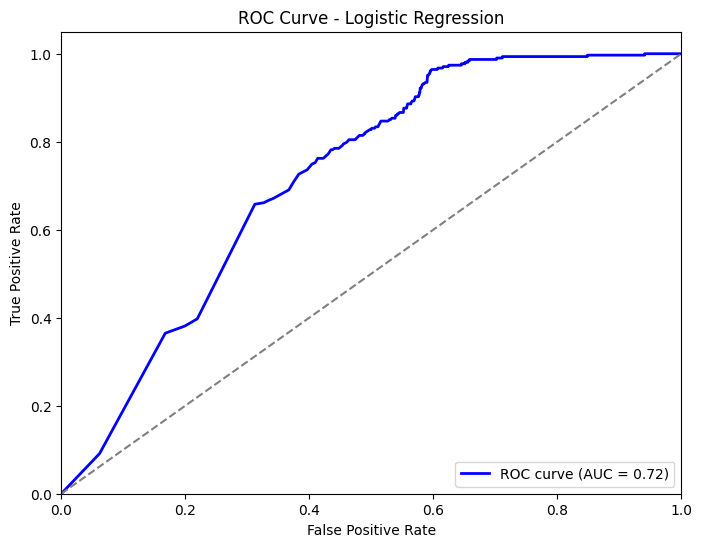

In [28]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score

def extract_features(clause_str):
    """
    Given a clause string (literals separated by spaces),
    count positive and negative literals.
    A literal is considered positive if its integer value is even,
    and negative if it is odd.
    Also computes the ratio = pos_count / neg_count (or pos_count if neg_count == 0).
    """
    literals = [int(x) for x in clause_str.split()]
    pos_count = sum(1 for x in literals if x % 2 == 0)
    neg_count = sum(1 for x in literals if x % 2 == 1)
    ratio = pos_count / neg_count if neg_count != 0 else pos_count
    return ratio, pos_count, neg_count

def process_directory(base_directory):
    """
    Process all CSV files inside the 'data' subdirectory of each given directory.
    Returns a list of clause strings that are in pripro_clauses.txt.
    """
    # Read allowed clauses from pripro_clauses.txt as integers

    clause_list = []
    for dir_name in os.listdir(base_directory):
        data_path = os.path.join(base_directory, dir_name, "data")
        if os.path.isdir(data_path):
            allowed_clauses = set()
            pripro_file = os.path.join(data_path, "pripro_clauses.txt")
            with open(pripro_file, "r") as f:
                  for line in f:
                        parts = line.split()
                        if len(parts) > 1:
                                allowed_clauses.add(int(parts[1]))  # Convert second number to int
            for file in glob.glob(os.path.join(data_path, "*.csv")):
                file_name = os.path.splitext(os.path.basename(file))[0]  # Get filename without .csv
                if not file_name.isdigit() or int(file_name) not in allowed_clauses:
                    continue  # Skip files that are not in allowed_clauses

                df = pd.read_csv(file)

                # Convert "Value" column to integers and filter allowed clauses
                df["Value"] = pd.to_numeric(df["Value"], errors="coerce")  # Convert to int, handle errors
                df = df.dropna(subset=["Value"])  # Drop rows where conversion failed
                df["Value"] = df["Value"].astype(int)  # Ensure integer type
                clause_str = " ".join(map(str, df["Value"].tolist()))  # Convert back to string
                clause_list.append(clause_str)

    return clause_list


base_directory = "/content"  # Change this to your base directory
# Process the directories to get a list of clause strings
clauses = process_directory(base_directory)
df_clauses = pd.DataFrame({"clause": clauses})

# Group by clause to count occurrences (target variable)
grouped = df_clauses.groupby("clause").size().reset_index(name="occurrences")

# Convert occurrences to binary target: 0 if occurrences=1, else 1
grouped["target"] = np.where(grouped["occurrences"] == 1, 0, 1)

# Extract features for each unique clause
features = grouped["clause"].apply(
    lambda s: pd.Series(extract_features(s), index=["ratio", "pos_count", "neg_count"])
)
grouped = pd.concat([grouped, features], axis=1)

# Prepare data for logistic regression
X = grouped[["ratio", "pos_count", "neg_count"]].values
y = grouped["target"].values

# Split into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities for ROC curve
y_scores = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_val, y_scores)
print(fpr)
print(tpr)
roc_auc = auc(fpr, tpr)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("ROC-AUC Score:", roc_auc)

# Save the model parameters to a file (for later use in C++)
with open("logistic_model.txt", "w") as f:
    f.write(f"{model.intercept_[0]}\n")
    f.write(",".join(map(str, model.coef_[0])) + "\n")
    f.write(f"ROC-AUC Score: {roc_auc}\n")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()



In [30]:
grouped["target"].value_counts()

,count
target,
0,122529
1,1382


In [31]:
df_clauses = pd.DataFrame({"clause": clauses})

# Group by clause to count occurrences (target variable)
_grouped = df_clauses.groupby("clause").size().reset_index(name="occurrences")
_grouped

,clause,occurrences
0,1 4 100,1
1,1 4 12,1
2,1 4 15 18 20 22 24 26 28 30 120 135 150 152 15...,1
3,1 4 343 345 16 18 19 22 24 26 28 30 1919 1921 ...,1
4,1 4 37,1
...,...,...
123906,99971 100259,1
123907,99971 99439 99737 101586,1
123908,99971 99973,1
123909,99978 99982,1
